# Figure 1: Full behavioral domain (BD) cerebellum-specific ALE (C-SALE) maps.
## Unthresholded maps, with thresholded (p < .001, k = 50) overlays.

## Additionally (in 1C): subdomain thresholded clusters, summarized by BD.

#### Author: Neville Magielse
#### Date: 25.07.2024

In [2]:
import os
import sys

# User-specified base working directory
BASE_DIR = '/data/project/cerebellum_ale/'  # Change this to your project folder. Make sure they have input and output folders.

# Defines input and output paths.
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

sys.path.append(os.path.join(BASE_DIR, 'scripts'))

In [3]:
# Imports
import numpy as np
import pandas as pd

import scipy
import scipy.spatial

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
import matplotlib.cm

import seaborn as sns
import nilearn.plotting, nilearn.maskers, nilearn.surface
import nibabel as nib

import nimare
from nimare.meta.cbma.ale import ALE
from nimare.correct import FWECorrector

# sys.path.append(os.path.join(BASE_DIR, 'scripts')). Utils is a custom python file with somme functions defined for this project.
from utils import cluster_extent_correction

import SUITPy.flatmap

In [4]:
# Create a font language
plt.rcParams["font.family"] = "Asana Math"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 192

# Prepare the C-SALE maps (thresholded and unthresholded)

In [7]:
## Cerebellar C-SALE - thresholded p < 0.001 and K = 50
zmaps = {}
surf_zmaps = {}
zmaps_thr = {}
surf_zmaps_thr = {}
zmaps_thr_strict = {}
surf_zmaps_thr_strict = {}

domains = ['Action', 'Cognition', 'Emotion', 'Perception', 'Interoception']
MASK_NAME = 'D2009_MNI'
mask_img = os.path.join(INPUT_DIR, f'maps/{MASK_NAME}.nii.gz')
k = 50

for domain in domains:
    domain_path = os.path.join(OUTPUT_DIR, 'SALE', f'{domain}')
    subdomains = os.listdir(domain_path)
    for subdomain in subdomains:
        subdomain_path = os.path.join(domain_path, subdomain)
        if (not os.path.isdir(subdomain_path)):
            continue
        print(subdomain)
        # load uncorrected results
        z_orig = nib.load(os.path.join(subdomain_path, 'uncorr_z.nii.gz'))
        # mask to the proper mask
        z_masked = nilearn.image.math_img("m * img", img=z_orig, m=mask_img)
        # record 3d and flattened unthresholded images
        zmaps[subdomain] = z_masked
        surf_zmaps[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps[subdomain], space = 'SPM').squeeze() # Set space to SPM. This parameter corresponds to the space of your data (base) (here: BrainMap).
        # do cluster extent thresholding if needed
        corr_cluster_z_path = os.path.join(subdomain_path, f'corr_cluster_h-01_k-{k}_mask-{MASK_NAME}_z.nii.gz')
        corr_cluster_z_path_strict = os.path.join(subdomain_path, f'corr_cluster_h-001_k-{k}_mask-{MASK_NAME}_z.nii.gz')
        if not os.path.exists(corr_cluster_z_path) and not os.path.exists(corr_cluster_z_path_strict): # If no thresholded results exist yet, you can create them here. Be careful correctly specifying these paths to prevent unnecessary calculations/ compute :).
            logp_orig = nib.load(os.path.join(subdomain_path, 'uncorr_logp.nii.gz'))
            logp_masked = nilearn.image.math_img("m * img", img=logp_orig, m=mask_img)
            # cluster extent correction
            cres = cluster_extent_correction({'z': z_masked, 'logp': logp_masked}, k=50, height_thr=0.001)
            # save corrected results
            for map_name, img in cres.items():
                img.to_filename(os.path.join(subdomain_path, f'corr_cluster_h-001_k-{k}_mask-{MASK_NAME}_{map_name}.nii.gz'))
        # record 3d and flattened thresholded (Lenient, p < 0.01 and K = 50) images
        zmaps_thr[subdomain] = nib.load(corr_cluster_z_path)
        surf_zmaps_thr[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps_thr[subdomain]).squeeze()
        # record 3d and flattened thresholded (Strict, p < 0.001 and K = 50) images
        zmaps_thr_strict[subdomain] = nib.load(corr_cluster_z_path_strict)
        surf_zmaps_thr_strict[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps_thr_strict[subdomain], space = 'SPM').squeeze()

# Verify that all your C-SALE results for (sub)BDs are printed and stored correctly in the dictionaries.

Action.MotorLearning
Action.Observation
Action.Execution.Speech
Action.Inhibition
Action.Execution
Action.Preparation
Action
Action.Imagination
Cognition.Spatial
Cognition.SocialCognition
Cognition.Attention
Cognition.Language.Syntax
Cognition.Memory
Cognition.Memory.Explicit
Cognition.Language
Cognition.Language.Semantics
Cognition
Cognition.Memory.Working
Cognition.Language.Phonology
Cognition.Reasoning
Cognition.Temporal
Cognition.Language.Speech
Cognition.Language.Orthography
Cognition.Music
Emotion.Positive.RewardGain
Emotion.Negative.Disgust
Emotion.Positive
Emotion
Emotion.Negative.Fear
Emotion.Positive.Happiness
Emotion.Negative.Sadness
Emotion.Negative
Emotion.Valence
Emotion.Negative.Anger
Emotion.Negative.Anxiety
Perception.Vision
Perception
Perception.Olfaction
Perception.Vision.Motion
Perception.Gustation
Perception.Somesthesis.Pain
Perception.Audition
Perception.Somesthesis
Perception.Vision.Color
Perception.Vision.Shape
Interoception.Sexuality
Interoception.RespirationRe

In [5]:
# Add the number of experiments, so we can order figures by the sample size:
domain_exps = {
    'Action': 583,
    'Cognition': 1522,
    'Emotion': 420,
    'Interoception': 124,
    'Perception': 652
}

# Prepare the SUIT flatmap surface mesh
## Obtained from the Diedrichsen lab. on 04.03.2024: https://github.com/DiedrichsenLab/SUITPy/blob/master/SUITPy/surfaces/FLAT.surf.gii

In [7]:
flat_mesh = nilearn.surface.load_surf_mesh(os.path.join(INPUT_DIR, 'maps/FLAT.surf.gii'))
flat_mesh

mesh(coordinates=array([[ 21.189785 ,   2.5686152,   0.       ],
       [ 20.541264 ,   2.4435081,   0.       ],
       [ 19.67503  ,   1.8180358,   0.       ],
       ...,
       [-29.824383 ,  74.66718  ,   0.       ],
       [-29.369013 ,  75.676094 ,   0.       ],
       [-29.696808 ,  75.297424 ,   0.       ]], dtype=float32), faces=array([[    0,     1,     7],
       [    8,     7,     1],
       [    0,   138,     1],
       ...,
       [27862, 27938, 27871],
       [27862, 27943, 27938],
       [27871, 27938, 27879]], dtype=int32))

## Try it out for one example result/ domain to check if it works & play around with visualisations.

In [8]:

# def get_flatmap_mask_boundaries(mask)
mask = (surf_zmaps_thr['Action']>0).astype(int)
outline = np.zeros_like(mask, dtype=int)
mesh = flat_mesh
boundary_faces = (mask[mesh.faces].sum(axis=1) == 1)
mask_boundary_verts = list(
    set(mesh.faces[boundary_faces].flatten()) & \
    set(np.where(mask)[0])
)
outline[mask_boundary_verts] = 1

In [9]:
mesh.coordinates.shape

(28935, 3)

In [10]:
mask_boundary_verts

[4102,
 12305,
 18,
 22550,
 4121,
 20509,
 4125,
 16415,
 34,
 14374,
 51,
 4148,
 18491,
 18492,
 28734,
 20543,
 18496,
 20544,
 74,
 4174,
 18514,
 18515,
 18516,
 22614,
 22615,
 22620,
 22621,
 10334,
 6244,
 14436,
 18538,
 18539,
 6255,
 2168,
 14458,
 10363,
 14460,
 6281,
 2188,
 16525,
 8335,
 2200,
 159,
 18592,
 2214,
 12454,
 16553,
 18601,
 18602,
 12460,
 12461,
 18603,
 12464,
 2229,
 6326,
 12476,
 12477,
 6334,
 14531,
 20676,
 2247,
 8391,
 6348,
 6349,
 2255,
 8402,
 16600,
 8415,
 14591,
 8456,
 6424,
 16670,
 6431,
 16677,
 16679,
 16684,
 20780,
 302,
 16687,
 304,
 6457,
 6458,
 6459,
 10564,
 16718,
 6479,
 24910,
 24929,
 12656,
 18801,
 18802,
 8578,
 14726,
 12702,
 18887,
 4556,
 14797,
 8658,
 4571,
 4586,
 4587,
 18929,
 18935,
 14840,
 12793,
 12794,
 4634,
 14878,
 4660,
 10807,
 14909,
 10820,
 19012,
 16967,
 19017,
 4682,
 4684,
 4685,
 19022,
 10831,
 19023,
 19024,
 16984,
 19051,
 17005,
 2670,
 2672,
 19062,
 2686,
 642,
 23172,
 4742,
 8848,
 6

In [11]:
iterations = 2
cluster_borders = mesh.coordinates[mask_boundary_verts]
for i in range(iterations):
    distmat = scipy.spatial.distance_matrix(cluster_borders, cluster_borders)
    distmat[distmat==0] = np.NaN
    neighbors = np.where(distmat < 5)
    new_points = (cluster_borders[neighbors[0]] + cluster_borders[neighbors[1]]) / 2
    cluster_borders = np.concatenate([cluster_borders, new_points], axis=0)

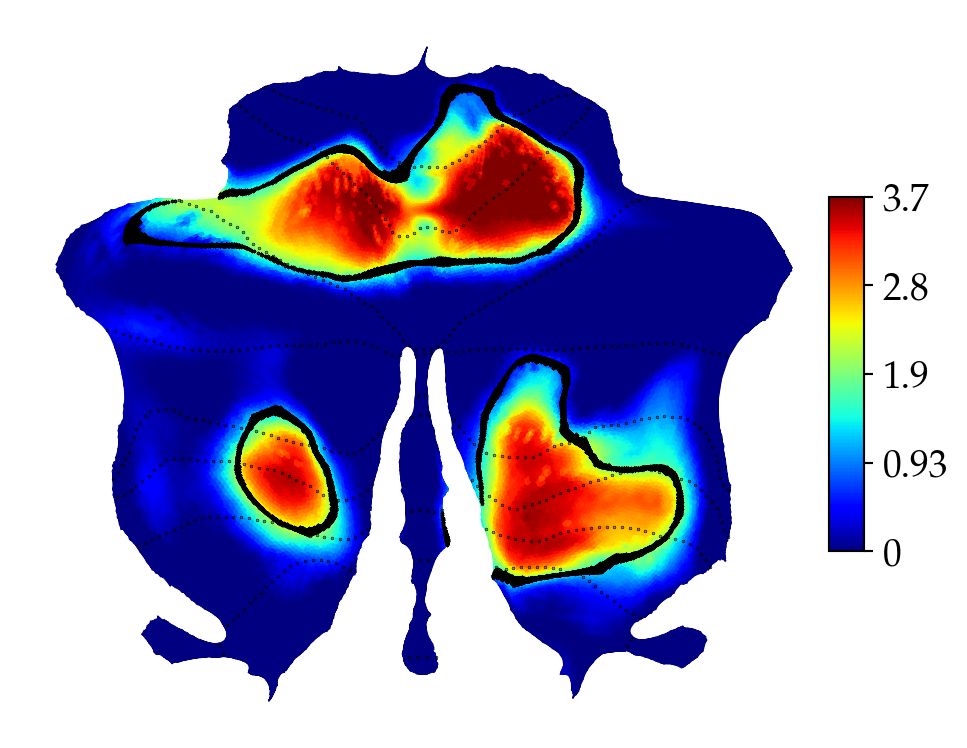

In [12]:
fig, ax = plt.subplots()
bordersize = 0.5
SUITPy.flatmap.plot(
    surf_zmaps['Action'],
    colorbar=True, new_figure=False, bordersize=bordersize)

ax.plot(cluster_borders[:,0],cluster_borders[:,1],color='black',
                marker='.', linestyle=None,
                markersize=0.5,linewidth=0)

# Now loop it over all (sub)BDs.

In [13]:
def get_flatmap_mask_boundaries(domain, surf_zmaps_thr):
    mask = (surf_zmaps_thr[domain] > 0).astype(int)
    outline = np.zeros_like(mask, dtype=int)
    mesh = nilearn.surface.load_surf_mesh(os.path.join(INPUT_DIR, 'maps/FLAT.surf.gii'))
    boundary_faces = (mask[mesh.faces].sum(axis=1) == 1)
    mask_boundary_verts = list(
        set(mesh.faces[boundary_faces].flatten()) & \
        set(np.where(mask)[0])
    )
    outline[mask_boundary_verts] = 1
    return outline

In [14]:
# Specifiy the domains
domains = ['Action', 'Cognition', 'Emotion', 'Interoception', 'Perception']

# Dictionary to store boundaries for each domain
boundaries_dict_strict = {}

# Iterate over domains and compute boundaries
for domain in domains:
    boundaries_dict_strict[domain] = get_flatmap_mask_boundaries(domain, surf_zmaps_thr_strict)

# This should now have put boundaries for every domain in boundaries_dict
# Check that keys exist for all domains.

In [15]:
# Load the surface mesh
mesh = flat_mesh

# Initialize dictionaries to store cluster borders, outline, and boundary faces for each domain
cluster_borders_dict_strict = {}
outline_dict_strict = {}
boundary_faces_dict_strict = {}

# Loop over domains
for domain in ['Action', 'Cognition', 'Emotion', 'Interoception', 'Perception']:
    # Get the binary mask for the current domain
    mask = (surf_zmaps_thr_strict[domain] > 0).astype(int)

    # Get the coordinates of the boundary vertices for the current domain
    outline_dict_strict[domain] = np.zeros_like(mask, dtype=int)
    boundary_faces_strict = (mask[mesh.faces].sum(axis=1) == 1)
    mask_boundary_verts_strict = list(
        set(mesh.faces[boundary_faces_strict].flatten()) & set(np.where(mask)[0])
    )
    cluster_borders_dict_strict[domain] = mesh.coordinates[mask_boundary_verts_strict]

    # Smoothing iterations
    iterations = 2
    for i in range(iterations):
        distmat = scipy.spatial.distance_matrix(cluster_borders_dict_strict[domain], cluster_borders_dict_strict[domain])
        distmat[distmat == 0] = np.NaN
        neighbors = np.where(distmat < 5)
        new_points = (cluster_borders_dict_strict[domain][neighbors[0]] + cluster_borders_dict_strict[domain][neighbors[1]]) / 2
        cluster_borders_dict_strict[domain] = np.concatenate([cluster_borders_dict_strict[domain], new_points], axis=0)

# This should have created a dicitionary of border outlines on the SUIT surface for every one of your (sub)BDs. Verify this. 
## Note that some parts of the outline may be somewhat wonky due to difficulties in mapping vertices to a 2D-surface.

# Figure 1a: unthresholded maps with conservatively thresholded (p < .001 and k = 50) overlays

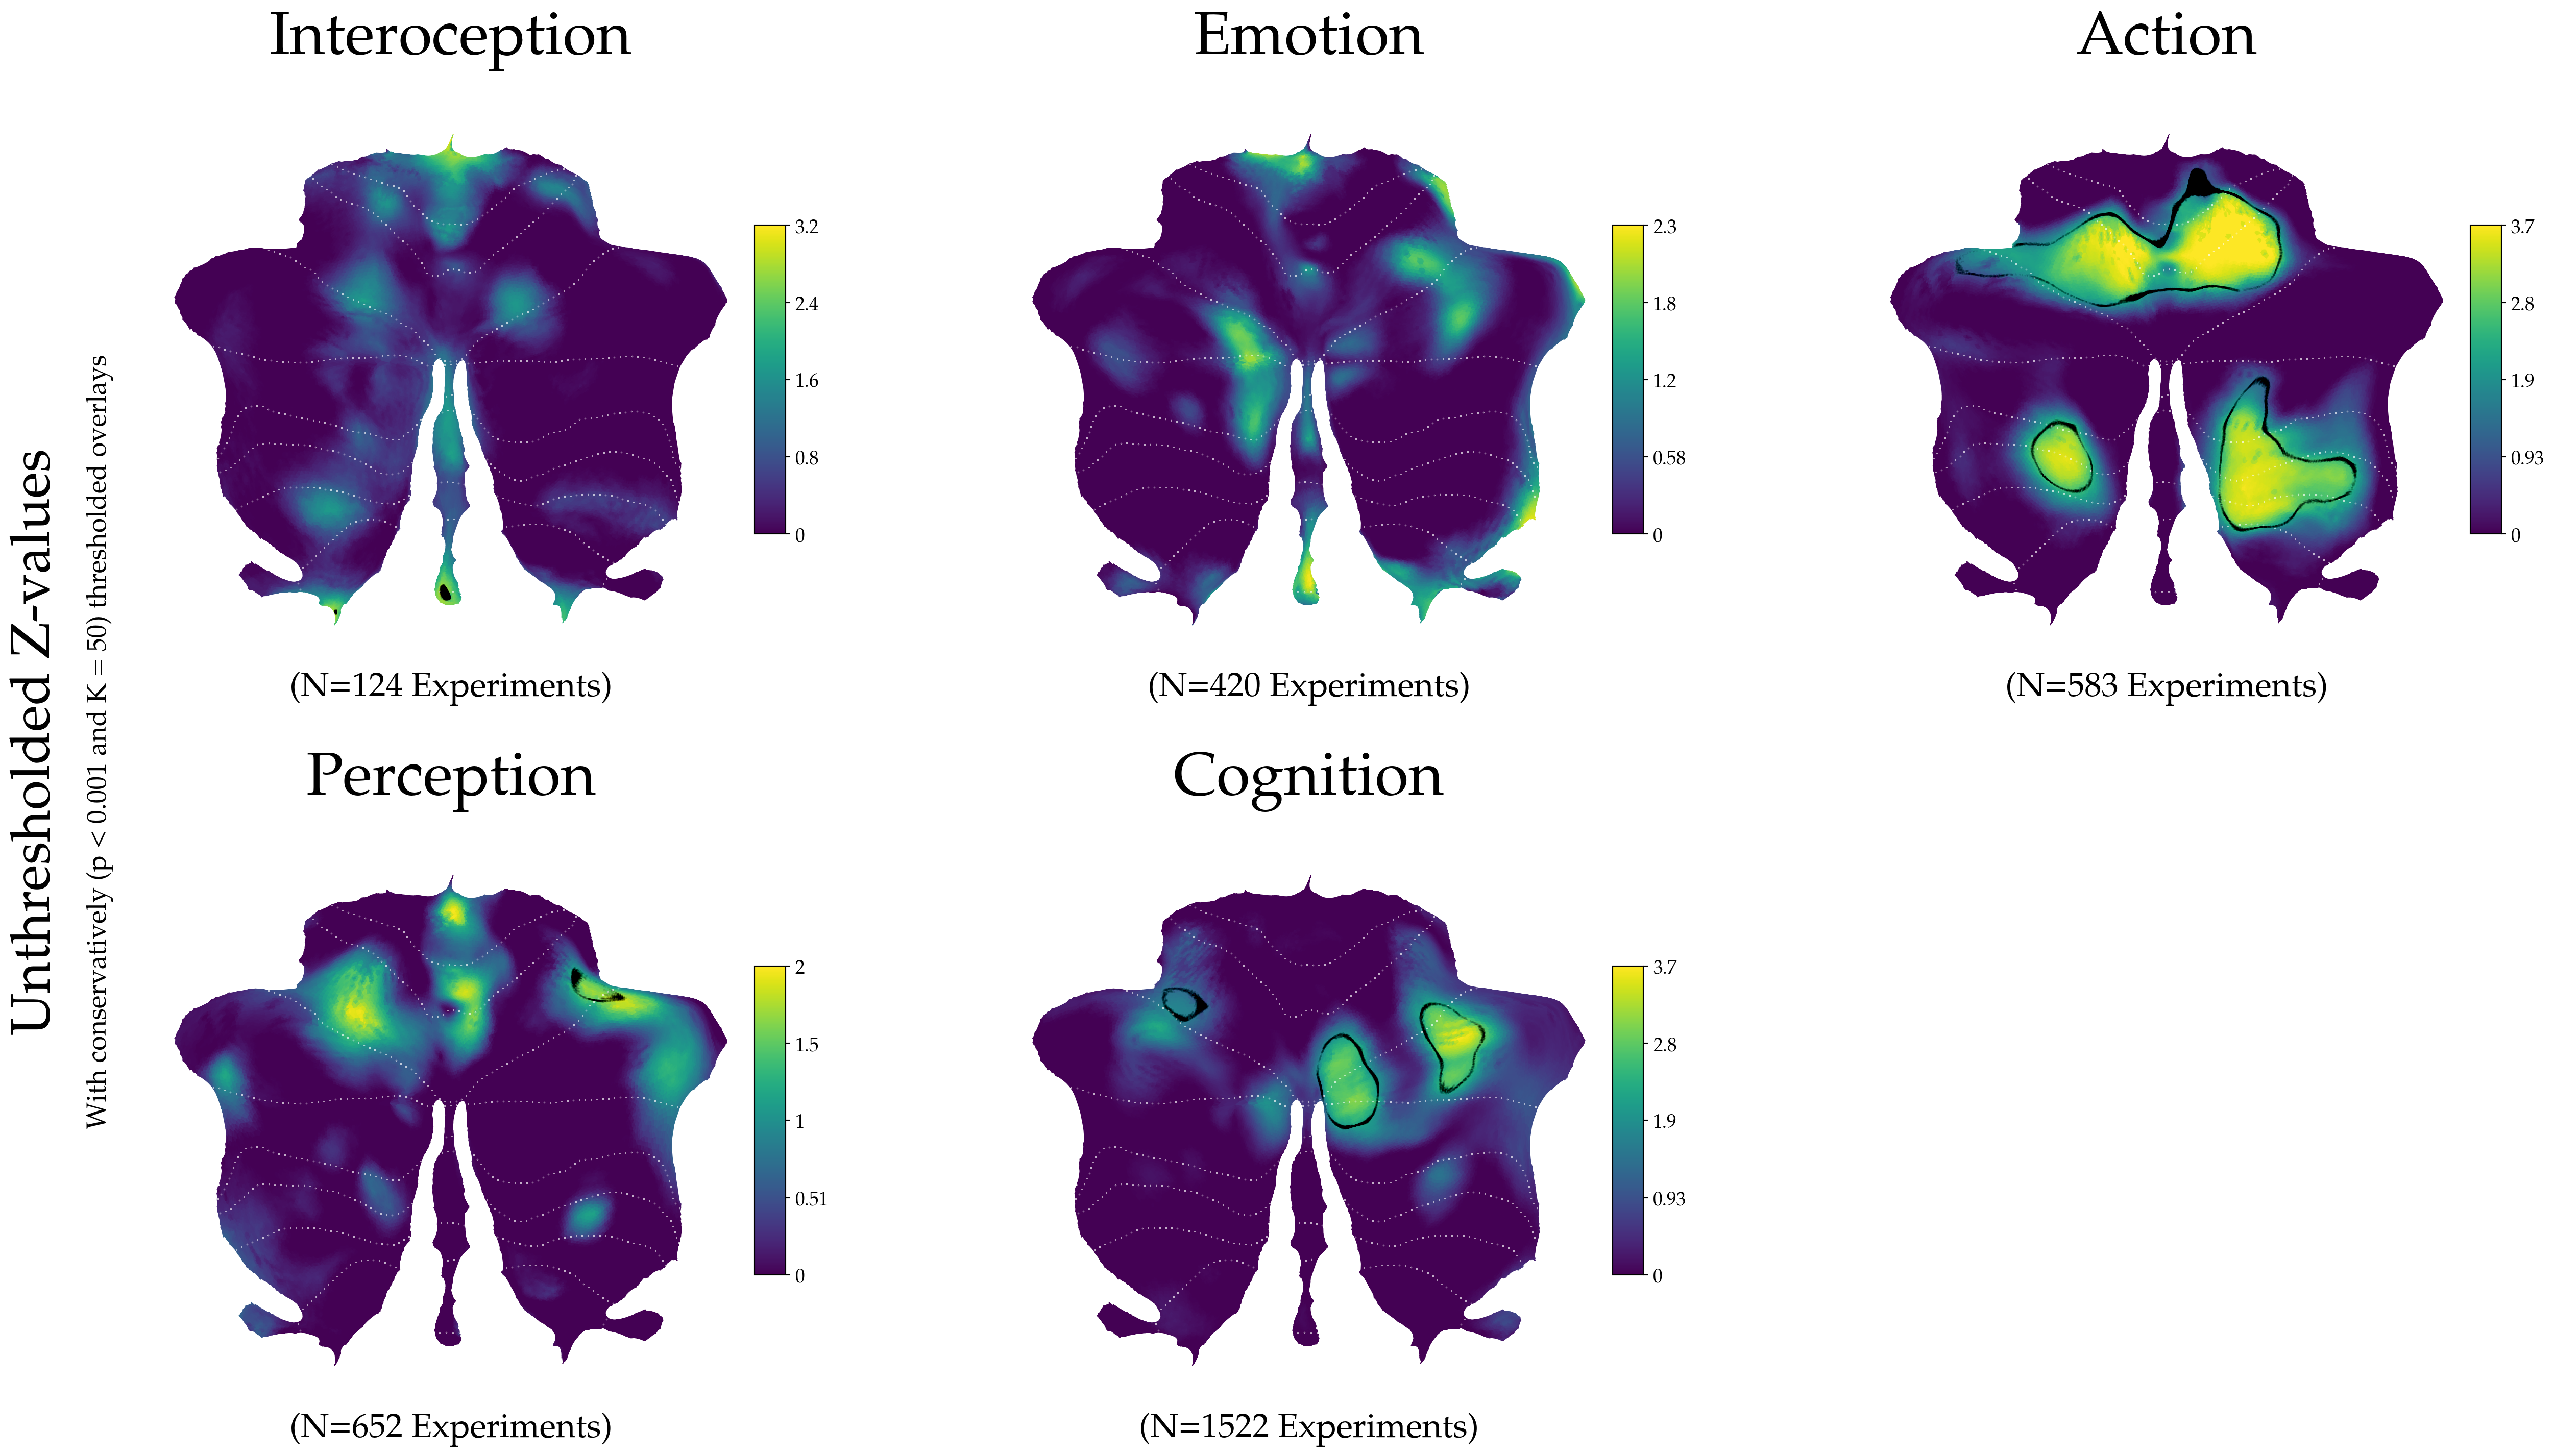

In [16]:
# Create a new figure
fig = plt.figure(figsize=(32, 18)) # Adjust to you publication preferences.

# Order the domains based on the number of experiments
domain_order = pd.Series(domain_exps).sort_values().index

# Loop over domains and create subplots for each of them
for i, domain in enumerate(domain_order):
    ax = fig.add_subplot(2, 3, i + 1)
    
    # Plot the unthresholded background map for each domain. Use a color blind-friendly colormap.
    SUITPy.flatmap.plot(surf_zmaps[domain], colorbar=True, new_figure=False, bordersize=0.5, cmap='viridis', bordercolor='white')

    # Overlay the cluster borders
    ax.plot(cluster_borders_dict_strict[domain][:, 0], cluster_borders_dict_strict[domain][:, 1], color='black',
            marker='.', linestyle=None, markersize=0.01, linewidth=0)

    # Set titles and labels as wanted
    ax.set_title(f"{domain}", fontsize=45)
    ax.text(0.5, 0.0, f'(N={domain_exps[domain]} Experiments)', fontsize=25, ha='center', va='center', transform=ax.transAxes)


# Add a rotated y-label for the entire plot
fig.text(0.09, 0.5, 'Unthresholded Z-values', va='center', ha='center', rotation='vertical', fontsize=40)

# Add a subtitle for the y-label
fig.text(0.11, 0.5, 'With conservatively (p < 0.001 and K = 50) thresholded overlays', va='center', ha='center', rotation='vertical', fontsize=20)

# Show the plot
plt.show()

In [ ]:
# Decide if you want to save the figure (at your own specified location)
#fig.savefig(os.path.join(BASE_DIR, 'Figures/SALE_maps/Figure1/SALE-BD-Unthre_w_thre_Fig1A.png'), bbox_inched = 'tight')

# Figure 1A: lobule legend (inset)

/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/SUITPy/flatmap.py:483: RuntimeWarning: All-NaN slice encountered
  cscale = np.array([np.nanmin(data), np.nanmax(data)])


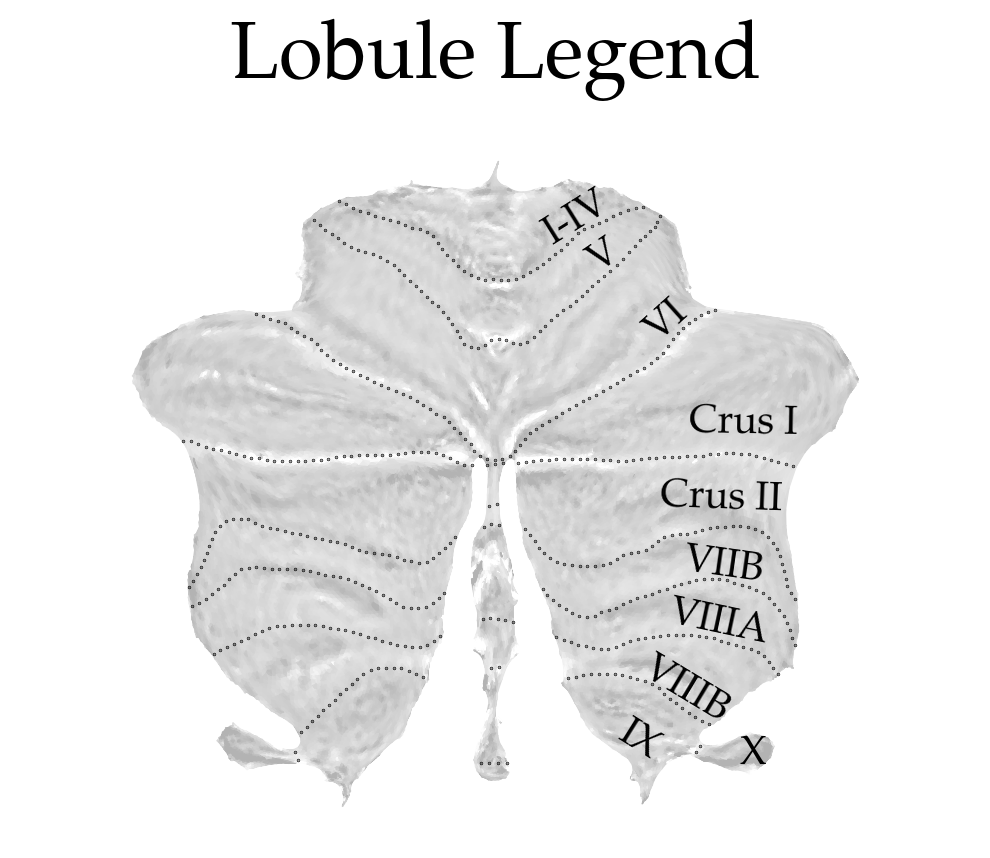

In [17]:
## A nice lobule-legend to add to the plot

fig, ax = plt.subplots(facecolor='none')

# Increase the alpha value to make the background less transparent
# bg_color = (1, 1, 1, 0.5)  # transparent white with higher alpha

# create milder grays
grays_mild = LinearSegmentedColormap.from_list(
    'grays_mild', 
    [
        (1, 1, 1, 1), 
        (0.7, 0.7, 0.7, 1)  # to make bg grayer, change 0.7 to lower values.
    ]
)

# Plot the background
SUITPy.flatmap.plot(surf_zmaps_thr['Action'] * np.NaN, # Create an empty (!) background, by multiplying by NaN.
                    colorbar=False, new_figure=False, bordersize=0.5, # Colorbar provides no information, new_figure = False to map all labels together, bordersize can be adjusted to visual preference.
                    undermap=grays_mild
                   )

ax.set_title('Lobule Legend', fontsize=30, y = 1.05)

# Manually add the lobule labels at specific locations and with rotations. Yes, this takes some trial-and-error :).
manual_labels = ['I-IV', 'V', 'VI', 'Crus I', 'Crus II', 'VIIB', 'VIIIA', 'VIIIB', 'IX', 'X'] # Based on the Larsell definition.
manual_label_positions = [(0.585, 0.875), (0.615, 0.82), (0.68, 0.73), (0.76, 0.585), (0.737, 0.48), (0.74, 0.385), (0.735, 0.305), (0.70, 0.21), (0.65, 0.140), (0.77, 0.12)]
manual_label_rotations = [32, 34, 42, -1, -2, -8, -12, -31, -32, 0]

for label, position, rotation in zip(manual_labels, manual_label_positions, manual_label_rotations):
    ax.text(position[0], position[1], label, fontsize=15, ha='center', va='center', transform=ax.transAxes, rotation=rotation, fontweight='bold')

plt.show()

In [ ]:
# Decide if you want to save the figure
# fig.savefig(os.path.join(BASE_DIR, 'Figures/SALE_maps/Figure1/Lobules-legend.png'), bbox_inches='tight')

# Figure 1B: Summarize thresholded cluster locations for all BDs with binary location mapping.

/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/SUITPy/flatmap.py:483: RuntimeWarning: All-NaN slice encountered
  cscale = np.array([np.nanmin(data), np.nanmax(data)])


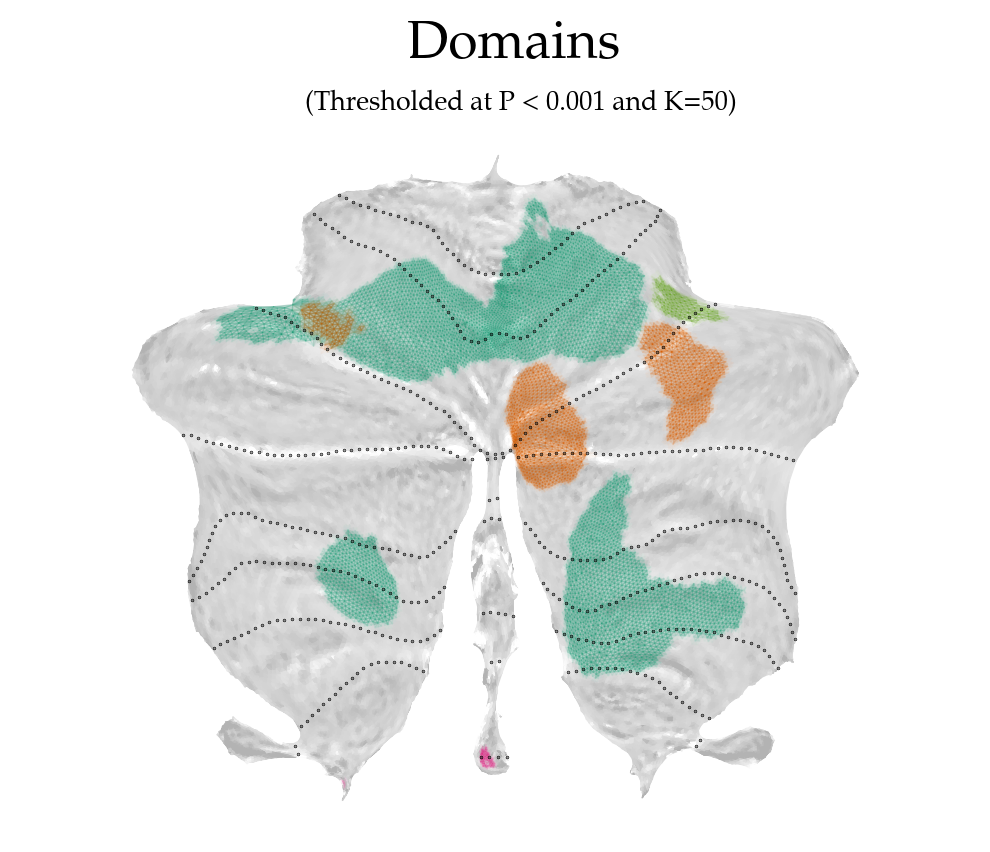

In [18]:
## Add-on for Figure 1: Transparent binarized clusters plot for domains; thresholded (p < 0.001 and K = 50) 

fig, ax = plt.subplots()

# background
# create milder greys
grays_mild = LinearSegmentedColormap.from_list(
    'grays_mild', 
    [
        (1, 1, 1, 1), 
        (0.7, 0.7, 0.7, 1) # to make bg grayer, change 0.7 to lower values
    ]
)
SUITPy.flatmap.plot(surf_zmaps_thr_strict['Action'] * np.NaN, 
                    colorbar=False, new_figure=False, bordersize=0.5, 
                    undermap=grays_mild
                   )

clusters_cmap = matplotlib.cm.get_cmap('Dark2')
clusters_colors = np.array([clusters_cmap(i) for i in range(clusters_cmap.N)])
bg_color = (1, 1, 1, 0) # transparent white at the lower end of all cmaps
clusters_colors[:, 3] = 0.2 # make cluster colors transparent. increase this to make clusters less transparent

# overlay thresholded clusters in a loop. Note that here new_figure = False is essential to overlay all together.
for i, domain in enumerate(domains):
    cmap = LinearSegmentedColormap.from_list('cluster', [bg_color, clusters_colors[i]])
    curr_surf = surf_zmaps_thr_strict[domain] > 0
    SUITPy.flatmap.plot(curr_surf, 
                        colorbar=False, new_figure=False, bordersize=0, 
                        backgroundcolor=(0, 0, 0, 0), 
                        underlay=np.zeros_like(curr_surf),
                        cmap=cmap, 
                       )
# Set the main title
main_title = "Domains"
ax.set_title(main_title, x=0.52, y= 1.07, fontsize=20)

# Set the subtitle
subtitle = "(Thresholded at P < 0.001 and K=50)"
ax.text(0.30, 1.02, subtitle, fontsize=10, style='italic', transform=ax.transAxes)

# chatgpt: create standalone legend
# Define your colors and labels
# colors = clusters_colors[:5, :3] # use to remove transparency from the legend colors
colors = clusters_colors[:5]
labels = ['Action', 'Cognition', 'Emotion', 'Interoception', 'Perception']

# Create patch objects for each color
patches = [Patch(color=color, label=label) for color, label in zip(colors, labels)]

# Create a legend based on the patch objects we created. Note I commented it out here since it is plotted as part of Figure 1c.
# legend = ax.legend(handles=patches, loc='center right', bbox_to_anchor=(1.1, 1.0)) 

In [ ]:
# Decide if you want to save the figure
# fig.savefig(os.path.join(BASE_DIR, 'Figures/SALE_maps/Figure1/SALE-BD-Thre-binarized_Fig1B.png'), bbox_inches='tight')

# Figure 1C: Thresholded subdomain results visually summarized per BD (binary cluster locations).

In [8]:
# all_subdomains will contain only subdomains.
domains = ['Action', 'Cognition', 'Emotion', 'Perception', 'Interoception']
MASK_NAME = 'D2009_MNI'
mask_img = os.path.join(INPUT_DIR, f'maps/{MASK_NAME}.nii.gz')
k = 50

all_subdomains = []  # Initialize an empty list to store all subdomains

for domain in domains:
    domain_path = os.path.join(OUTPUT_DIR, 'SALE', f'{domain}')
    all_domains = os.listdir(domain_path)
    
    # Exclude subdomains with the same name as the domains
    subdomains = [subdomain for subdomain in all_domains if subdomain not in domains]
    all_subdomains.extend(subdomains)  # Add the subdomains to the list
    
    for subdomain in subdomains:
        subdomain_path = os.path.join(domain_path, subdomain)
        if (not os.path.isdir(subdomain_path)):
            continue
        print(subdomain)
        # load uncorrected results
        z_orig = nib.load(os.path.join(subdomain_path, 'uncorr_z.nii.gz'))
        # mask to the proper mask
        z_masked = nilearn.image.math_img("m * img", img=z_orig, m=mask_img)
        # record 3d and flattened unthresholded images
        zmaps[subdomain] = z_masked
        surf_zmaps[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps[subdomain], space = 'SPM').squeeze()
        # do cluster extent thresholding if needed
        corr_cluster_z_path = os.path.join(subdomain_path, f'corr_cluster_h-01_k-{k}_mask-{MASK_NAME}_z.nii.gz')
        corr_cluster_z_path_strict = os.path.join(subdomain_path, f'corr_cluster_h-001_k-{k}_mask-{MASK_NAME}_z.nii.gz')
        if not os.path.exists(corr_cluster_z_path):
            logp_orig = nib.load(os.path.join(subdomain_path, 'uncorr_logp.nii.gz'))
            logp_masked = nilearn.image.math_img("m * img", img=logp_orig, m=mask_img)
            # cluster extent correction
            cres = cluster_extent_correction({'z': z_masked, 'logp': logp_masked}, k=50, height_thr=0.01)
            # save corrected results
            for map_name, img in cres.items():
                img.to_filename(os.path.join(subdomain_path, f'corr_cluster_h-01_k-{k}_mask-{MASK_NAME}_{map_name}.nii.gz'))
        # record 3d and flattened thresholded images
        zmaps_thr[subdomain] = nib.load(corr_cluster_z_path)
        surf_zmaps[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps_thr[subdomain], space = 'SPM').squeeze()
        # record 3d and flattened thresholded (Strict, p<0.001 and K=50) images
        zmaps_thr_strict[subdomain] = nib.load(corr_cluster_z_path_strict)
        surf_zmaps_thr_strict[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps_thr_strict[subdomain], space = 'SPM').squeeze()

Action.MotorLearning
Action.Observation
Action.Execution.Speech
Action.Inhibition
Action.Execution
Action.Preparation
Action.Imagination
Cognition.Spatial
Cognition.SocialCognition
Cognition.Attention
Cognition.Language.Syntax
Cognition.Memory
Cognition.Memory.Explicit
Cognition.Language
Cognition.Language.Semantics
Cognition.Memory.Working
Cognition.Language.Phonology
Cognition.Reasoning
Cognition.Temporal
Cognition.Language.Speech
Cognition.Language.Orthography
Cognition.Music
Emotion.Positive.RewardGain
Emotion.Negative.Disgust
Emotion.Positive
Emotion.Negative.Fear
Emotion.Positive.Happiness
Emotion.Negative.Sadness
Emotion.Negative
Emotion.Valence
Emotion.Negative.Anger
Emotion.Negative.Anxiety
Perception.Vision
Perception.Olfaction
Perception.Vision.Motion
Perception.Gustation
Perception.Somesthesis.Pain
Perception.Audition
Perception.Somesthesis
Perception.Vision.Color
Perception.Vision.Shape
Interoception.Sexuality
Interoception.RespirationRegulation
Interoception.Hunger


/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/SUITPy/flatmap.py:483: RuntimeWarning: All-NaN slice encountered
  cscale = np.array([np.nanmin(data), np.nanmax(data)])


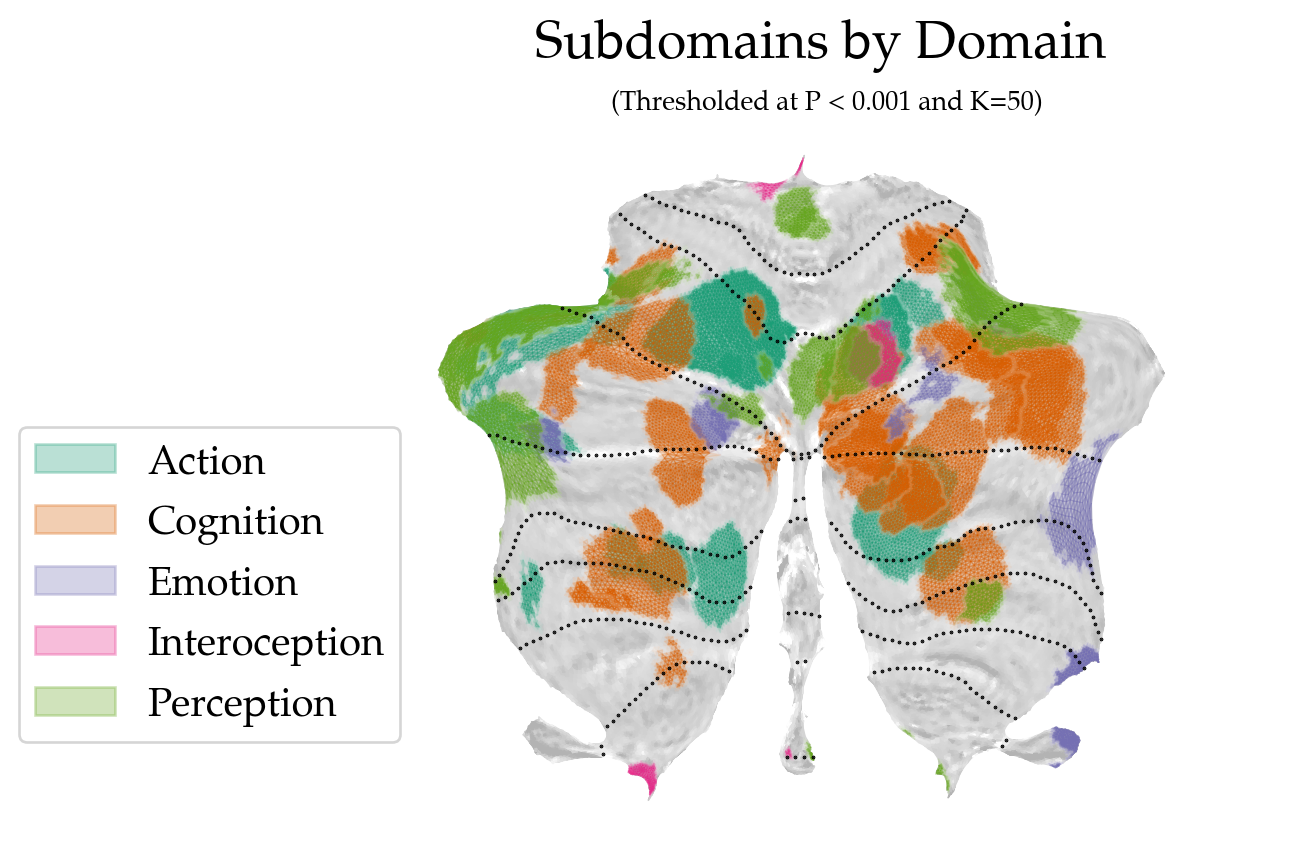

In [10]:
# Create a new figure
fig, ax = plt.subplots()

# Increase the alpha value to make the background less transparent
# bg_color = (1, 1, 1, 0.5)  # transparent white with higher alpha

# create milder greys
grays_mild = LinearSegmentedColormap.from_list(
    'grays_mild', 
    [
        (1, 1, 1, 1), 
        (0.7, 0.7, 0.7, 1)  # to make bg grayer, change 0.7 to lower values
    ]
)

# Plot the background
SUITPy.flatmap.plot(surf_zmaps_thr['Action.Execution'] * np.NaN, # This can be any cerebellar flatmap, just make sure to multiply it by NaNs.
                    colorbar=False, new_figure=False, bordersize=0.8, 
                    undermap=grays_mild
                   )

# Set colors to correspond to Figure 1A inset.
clusters_cmap = matplotlib.cm.get_cmap('Dark2')
clusters_colors = np.array([clusters_cmap(i) for i in range(clusters_cmap.N)]) # Systematically take the first 5 colors of the Dark2 colormap.
bg_color = (1, 1, 1, 0) # transparent white at the lower end of all cmaps
clusters_colors[:, 3] = 0.3 # make cluster colors transparent. Increase this number/ the alpha to make clusters less transparent.

# Define the colors for each domain
domain_colors = {
    'Action': clusters_colors[0],
    'Cognition': clusters_colors[1],
    'Emotion': clusters_colors[2],
    'Interoception': clusters_colors[3],
    'Perception': clusters_colors[4]
}

# Store legend handles for each domain
legend_handles = [Patch(color=color, label=domain) for domain, color in domain_colors.items()]

# Overlay clusters for each domain
for domain, color in domain_colors.items():
    # Filter subdomains based on the domain their names start with 
    domain_subdomains = [subdomain for subdomain in all_subdomains if subdomain.startswith(domain)]

    # Overlay clusters in a loop using the matching key for subdomains
    for subdomain in domain_subdomains:
        matching_keys = [key for key in surf_zmaps_thr_strict.keys() if f'{subdomain}' in key] # use strict dictionary

        if matching_keys:
            cmap = LinearSegmentedColormap.from_list('cluster', [bg_color, color])
            curr_surf = surf_zmaps_thr_strict[matching_keys[0]] > 0
            SUITPy.flatmap.plot(curr_surf, 
                                colorbar=False, new_figure=False, bordersize=0, 
                                backgroundcolor=(0, 0, 0, 0), 
                                underlay=np.zeros_like(curr_surf),
                                cmap=cmap, 
                               )
        else:
            # Handle the case when no matching key is found (you may want to add some fallback behavior)
            print(f"No matching key found for subdomain: {subdomain}")

# Set the main title
main_title = "Subdomains by Domain"
ax.set_title(main_title, x=0.52, y= 1.07, fontsize=20)

# Set the subtitle
subtitle = "(Thresholded at P < 0.001 and K=50)"
ax.text(0.30, 1.02, subtitle, fontsize=10, style='italic', transform=ax.transAxes)

# Create a legend with the domain names
legend = ax.legend(handles=legend_handles, 
                loc='center right', bbox_to_anchor=(0.1, 0.35), prop={'size': 15}) # Here we plot the legend.

plt.show()

# Note that this takes a while.

In [13]:
# Decide if you want to save the figure
fig.savefig(os.path.join(BASE_DIR, 'Figures/SALE_maps/Figure1/SALE-Subd-colored-by-domain_1C.png'), bbox_inches='tight')

# The End.